In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Opening FARS Data into a pandas dataframe

In [2]:
Accident2014 = 'https://crashviewer.nhtsa.dot.gov/CrashAPI/FARSData/GetFARSData?dataset=Accident&caseYear=2014&format=csv'

# Read the URL into a panda df
dfAccident2014 = pd.read_csv(Accident2014)

# Print the first few contents to test
dfAccident2014.head()

,caseyear,state,st_case,statename,ve_total,ve_forms,pvh_invl,peds,pernotmvit,permvit,persons,county,countyname,city,cityname,day,month,monthname,year,day_week,day_weekname,hour,hourname,minute,minutename,nhs,nhsname,rur_urb,rur_urbname,func_sys,func_sysname,rd_owner,rd_ownername,route,routename,tway_id,tway_id2,milept,mileptname,latitude,...,typ_int,typ_intname,wrk_zone,wrk_zonename,road_fnc,road_fncname,rel_road,rel_roadname,lgt_cond,lgt_condname,weather1,weather1name,weather2,weather2name,weather,weathername,sch_bus,sch_busname,rail,railname,not_hour,not_hourname,not_min,not_minname,arr_hour,arr_hourname,arr_min,arr_minname,hosp_hr,hosp_hrname,hosp_mn,hosp_mnname,cf1,cf1name,cf2,cf2name,cf3,cf3name,fatals,drunk_dr
0,2014,1,10001,Alabama,1,1,0,0,0,2,2,71,JACKSON (71),0,NOT APPLICABLE,1,1,January,2014,4,Wednesday,1,1:00am-1:59am,15,15,0,This section IS NOT on the NHS,NaN,NaN,NaN,NaN,NaN,NaN,4,County Road,CR-67,NaN,0,None,34.623722,...,1,Not an Intersection,0,None,5,Rural-Minor Collector,4,On Roadside,2,Dark - Not Lighted,1,Clear,0,No Additional Atmospheric Conditions,1,Clear,0,No,0000000,Not Applicable,99,Unknown,99,Unknown,1,1:00am-1:59am,35,35,99,Unknown,99,Unknown EMS Hospital Arrival Time,0,None,0,None,0,None,1,1
1,2014,1,10002,Alabama,1,1,0,0,0,1,1,59,FRANKLIN (59),0,NOT APPLICABLE,1,1,January,2014,4,Wednesday,13,1:00pm-1:59pm,30,30,0,This section IS NOT on the NHS,NaN,NaN,NaN,NaN,NaN,NaN,4,County Road,CR-26,NaN,0,None,34.397428,...,1,Not an Intersection,0,None,6,Rural-Local Road or Street,4,On Roadside,1,Daylight,1,Clear,0,No Additional Atmospheric Conditions,1,Clear,0,No,0000000,Not Applicable,99,Unknown,99,Unknown,13,1:00pm-1:59pm,50,50,99,Unknown,99,Unknown EMS Hospital Arrival Time,0,None,0,None,0,None,1,1
2,2014,1,10003,Alabama,2,2,0,0,0,7,7,125,TUSCALOOSA (125),3050,TUSCALOOSA,1,1,January,2014,4,Wednesday,3,3:00am-3:59am,7,7,1,This section IS ON the NHS,NaN,NaN,NaN,NaN,NaN,NaN,2,U.S. Highway,US-SR 6,VERTERAN'S MEMORIAL PKWY,0,None,33.197172,...,2,Four-Way Intersection,0,None,13,Urban-Other Principal Arterial,1,On Roadway,3,Dark - Lighted,1,Clear,0,No Additional Atmospheric Conditions,1,Clear,0,No,0000000,Not Applicable,99,Unknown,99,Unknown,3,3:00am-3:59am,10,10,99,Unknown,99,Unknown EMS Hospital Arrival Time,0,None,0,None,0,None,2,0
3,2014,1,10004,Alabama,3,3,0,0,0,5,5,121,TALLADEGA (121),2275,OAK GROVE,2,1,January,2014,5,Thursday,9,9:00am-9:59am,0,0,1,This section IS ON the NHS,NaN,NaN,NaN,NaN,NaN,NaN,2,U.S. Highway,US-SR 38,NaN,391,391,33.196383,...,1,Not an Intersection,0,None,13,Urban-Other Principal Arterial,1,On Roadway,1,Daylight,2,Rain,0,No Additional Atmospheric Conditions,2,Rain,0,No,0000000,Not Applicable,99,Unknown,99,Unknown,9,9:00am-9:59am,15,15,99,Unknown,99,Unknown EMS Hospital Arrival Time,0,None,0,None,0,None,1,0
4,2014,1,10005,Alabama,1,1,0,0,0,1,1,43,CULLMAN (43),0,NOT APPLICABLE,2,1,January,2014,5,Thursday,16,4:00pm-4:59pm,30,30,0,This section IS NOT on the NHS,NaN,NaN,NaN,NaN,NaN,NaN,4,County Road,CR-719,NaN,0,None,34.180189,...,1,Not an Intersection,0,None,5,Rural-Minor Collector,4,On Roadside,1,Daylight,1,Clear,0,No Additional Atmospheric Conditions,1,Clear,0,No,0000000,Not Applicable,99,Unknown,99,Unknown,12,12:00pm-12:59pm,45,45,88,Not Applicable (Not Transported),88,Not Applicable (Not Transported),0,None,0,None,0,None,1,0


statename
Alabama                 235
Alaska                   26
Arizona                 177
Arkansas                115
California              839
Colorado                158
Connecticut              76
Delaware                 43
District of Columbia      5
Florida                 613
Georgia                 244
Hawaii                   30
Idaho                    55
Illinois                282
Indiana                 149
Iowa                     78
Kansas                  101
Kentucky                177
Louisiana               230
Maine                    43
Maryland                122
Massachusetts           101
Michigan                217
Minnesota                95
Mississippi             127
Missouri                212
Montana                  83
Nebraska                 79
Nevada                   88
New Hampshire            30
New Jersey              122
New Mexico              105
New York                208
North Carolina          358
North Dakota             52
Ohio      

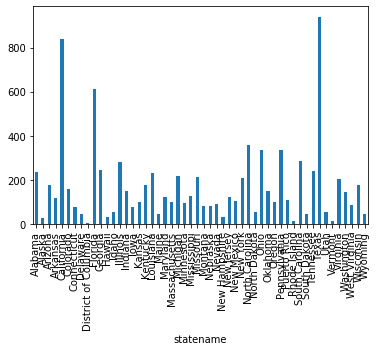

In [3]:
# Split the data to only show drunk driving cases
drunkAccidents2014 = dfAccident2014[dfAccident2014.drunk_dr > 0]

# Group drunk driving cases by state
drunkAccidents2014byState = drunkAccidents2014.groupby('statename')

# Print the results
print(drunkAccidents2014byState.size())

# Plot the results as a bar graph
drunkAccidents2014byState.size().plot(kind='bar')

In [4]:
#People in FARS 2014
People2014 = 'https://crashviewer.nhtsa.dot.gov/CrashAPI/FARSData/GetFARSData?dataset=Person&caseYear=2014&format=csv'

dfPeople2014 = pd.read_csv(People2014)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Take only State, CaseID, Seat Position, Alcohol Status, and Alcohol Result
dfPeople2014 = dfPeople2014.loc[:,['state','statename','st_case','seat_pos','alc_status','alc_res']]
# Use Seat Position to split into Drivers (seat_pos == 11)
drivers2014 = dfPeople2014[dfPeople2014['seat_pos'] == 11]

# Further split to drunk drivers (alc_status == 2 "test given", alc_res > 0 "BAC at least 0.01")

# Knowns (Truth) where alc_res < 95(alc_res=94 means BAC of 0.94 and above)
# If alc_res > 95 but alc_status == 2 A test was given but results unknown and not useful as a label

In [0]:
#Match the drivers with accident cases of drunk drivers via st case 
drunk_drivers_cases_2014 = drivers2014.loc[drivers2014['st_case'].isin(drunkAccidents2014.st_case)]
#Make sure the drivers was tested for alcohol test (alc_status = 2)
dfmatched2014 = drunk_drivers_cases_2014.loc[drunk_drivers_cases_2014['alc_status'] == 2]

#Make sure the alcohol level was determined (https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812559)
dfmatched2014 = dfmatched2014.loc[(dfmatched2014['alc_res'] > 0) & (dfmatched2014['alc_res'] < 95)]

# Take the drivers with highest alcohol result for duplicated st_case
dfno_duplicates = dfmatched2014.groupby('st_case', group_keys=False).apply(lambda x: x.loc[x.alc_res.idxmax()])
# Dataframe with one drivers per st_case number

In [7]:
# Reset index for dataframes before merging
dfno_duplicates = dfno_duplicates.reset_index(drop = True)
drunkAccidents2014 = drunkAccidents2014.reset_index(drop = True)
# Merge the dataset from accident into the drivers
dfmerged2014 = pd.merge(dfno_duplicates, drunkAccidents2014, on='st_case')
# Returns the shape of the merged dataset
dfmerged2014.shape

(7682, 98)

In [8]:
# Dropping redundant columns
columns_to_drop = ['statename_x', 'statename_y', 'countyname', 'cityname', 'monthname', 'day_weekname', 'hourname', 'nhsname', 'routename', 'typ_intname', 'road_fncname', 'rel_roadname', 'lgt_condname', 'weather1name', 'weather2name', 'weathername', 'sch_busname', 'railname', 'not_hourname', 'not_minname', 'arr_hourname', 'hosp_hrname', 'hosp_mnname', 'cf1name', 'cf2name', 'cf3name']
dfcleaned_2014 = dfmerged2014.drop(columns = columns_to_drop)
# Dropping columns with string
columns_to_drop2 = ['rail', 'tway_id', 'mileptname', 'sp_jurname', 'harm_evname', 'man_collname', 'reljct1name', 'reljct2name', 'wrk_zonename', 'arr_minname', 'minutename', 'latitudename', 'longitudname']
dfcleaned_2014 = dfcleaned_2014.drop(columns = columns_to_drop2)
# Dropping columns with NaN
dfcleaned_2014 = dfcleaned_2014.dropna(axis='columns')
# cleaned df shape
dfcleaned_2014.shape

(7682, 52)

In [9]:
# cleaned df sample
dfcleaned_2014.head()

,state_x,st_case,seat_pos,alc_status,alc_res,caseyear,state_y,ve_total,ve_forms,pvh_invl,peds,pernotmvit,permvit,persons,county,city,day,month,year,day_week,hour,minute,nhs,route,milept,latitude,longitud,sp_jur,harm_ev,man_coll,reljct1,reljct2,typ_int,wrk_zone,road_fnc,rel_road,lgt_cond,weather1,weather2,weather,sch_bus,not_hour,not_min,arr_hour,arr_min,hosp_hr,hosp_mn,cf1,cf2,cf3,fatals,drunk_dr
0,1,10001,11,2,26,2014,1,1,1,0,0,0,2,2,71,0,1,1,2014,4,1,15,0,4,0,34.623722,-85.981408,0,17,0,0,1,1,0,5,4,2,1,0,1,0,99,99,1,35,99,99,0,0,0,1,1
1,1,10002,11,2,31,2014,1,1,1,0,0,0,1,1,59,0,1,1,2014,4,13,30,0,4,0,34.397428,-87.772117,0,42,0,0,1,1,0,6,4,1,1,0,1,0,99,99,13,50,99,99,0,0,0,1,1
2,1,10007,11,2,17,2014,1,3,2,1,0,0,2,2,97,2100,3,1,2014,6,18,40,0,6,0,30.660114,-88.070231,0,12,7,0,1,1,0,16,1,3,10,0,10,0,99,99,18,48,88,88,0,0,0,1,1
3,1,10012,11,2,2,2014,1,2,1,1,0,1,1,2,97,2100,8,1,2014,4,12,34,1,6,0,30.682400,-88.225442,0,14,0,0,1,1,0,13,5,1,1,0,1,0,99,99,12,39,99,99,0,0,0,1,1
4,1,10013,11,2,33,2014,1,1,1,0,0,0,1,1,53,0,8,1,2014,4,15,47,0,4,0,31.180089,-87.438331,0,38,0,0,1,1,0,3,5,1,1,0,1,0,99,99,16,21,88,88,0,0,0,1,1


In [0]:
# Put data into X and Y
X = dfcleaned_2014
Xcolumns_to_drop = ['alc_res','st_case']
X = X.drop(columns = Xcolumns_to_drop)
y = dfcleaned_2014['alc_res']

In [0]:
# Preprocess the label into bins (group alc_res into 3 bins)
yarray = y.to_numpy()
Discretizer = preprocessing.KBinsDiscretizer(n_bins = 3, encode= 'ordinal', strategy='uniform')
Discretizer.fit(yarray.reshape(-1,1)) 
yt = Discretizer.transform(yarray.reshape(-1,1))

# Visualize the way the Alcohol Level was Binned

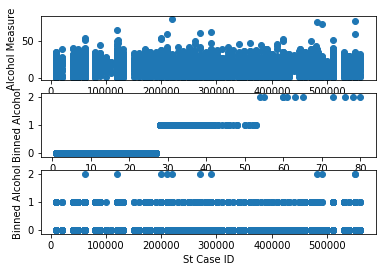

In [12]:
plt.figure('alctransform')
plt.subplot(311)
plt.xlabel('St Case ID')
plt.ylabel('Alcohol Measure')
plt.scatter(dfcleaned_2014['st_case'],y)

plt.subplot(312)
plt.xlabel('Alcohol Measure')
plt.ylabel('Binned Alcohol')
plt.scatter(y,yt)

plt.subplot(313)
plt.xlabel('St Case ID')
plt.ylabel('Binned Alcohol')
plt.scatter(dfcleaned_2014['st_case'],yt)

plt.show()

In [0]:
# Introduce Test-Train Split using the binned labels 80train:20test
from sklearn.model_selection import train_test_split
trainX,testX,trainyt,testyt=train_test_split(X,yt,test_size=.20,random_state=72)

In [14]:
# Ensemble Learning - Forest
from sklearn.ensemble import RandomForestClassifier

# Define the regressors
forestGiniBoot = RandomForestClassifier(n_estimators=100, criterion='gini',bootstrap=True)
# Fit the regressor
print (forestGiniBoot.fit(trainX, trainyt), "\n\n")
# print the mean accuracy 
print("accuracy", forestGiniBoot.score(testX, testyt)) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 


accuracy 0.9134677944046844


In [15]:
columnsNamesArr = X.columns.values
importanceForest = forestGiniBoot.feature_importances_

matchedForest = pd.DataFrame(importanceForest,columnsNamesArr)
print(matchedForest)

                   0
state_x     0.032563
seat_pos    0.000000
alc_status  0.000000
caseyear    0.000000
state_y     0.035601
ve_total    0.008327
ve_forms    0.005748
pvh_invl    0.004325
peds        0.001945
pernotmvit  0.002700
permvit     0.013029
persons     0.013519
county      0.062399
city        0.035327
day         0.051242
month       0.044988
year        0.000000
day_week    0.032144
hour        0.044708
minute      0.054533
nhs         0.008088
route       0.026647
milept      0.041327
latitude    0.067271
longitud    0.067277
sp_jur      0.001715
harm_ev     0.037451
man_coll    0.013058
reljct1     0.002590
reljct2     0.012134
typ_int     0.010228
wrk_zone    0.001613
road_fnc    0.037967
rel_road    0.014352
lgt_cond    0.018749
weather1    0.010747
weather2    0.002802
weather     0.011451
sch_bus     0.000000
not_hour    0.024352
not_min     0.035080
arr_hour    0.023597
arr_min     0.034198
hosp_hr     0.017311
hosp_mn     0.018551
cf1         0.005954
cf2         0

In [16]:
matchedForest.sort_values(0,ascending=False)

,0
longitud,0.067277
latitude,0.067271
county,0.062399
minute,0.054533
day,0.051242
month,0.044988
hour,0.044708
milept,0.041327
road_fnc,0.037967
harm_ev,0.037451


/usr/local/lib/python3.6/dist-packages/yellowbrick/classifier/base.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


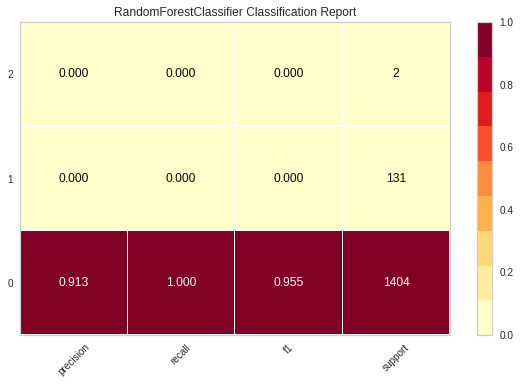

In [17]:
#Classification Report
from sklearn.metrics import classification_report
from yellowbrick.classifier import ClassificationReport
viz = ClassificationReport(forestGiniBoot, classes=['0', '1', '2'], support = True)
viz.fit(trainX, trainyt)
viz.score(testX, testyt)
viz.poof()

In [18]:
# Ensemble Learning - ADA boost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier

# Define the regressor
ada = AdaBoostClassifier(random_state=0, n_estimators=500, algorithm='SAMME')
# Fit the regressor
print (ada.fit(trainX, trainyt), "\n\n")
# print the mean accuracy 
print("accuracy", ada.score(testX, testyt)) 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
                   n_estimators=500, random_state=0) 


accuracy 0.8939492517891997


In [19]:
#Test Prediction
ypred = ada.predict(testX)
ybins = np.bincount(yt.astype(int).ravel())
ii = np.nonzero(ybins)[0]
np.vstack((ii,ybins[ii])).T


array([[   0, 7004],
       [   1,  667],
       [   2,   11]])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


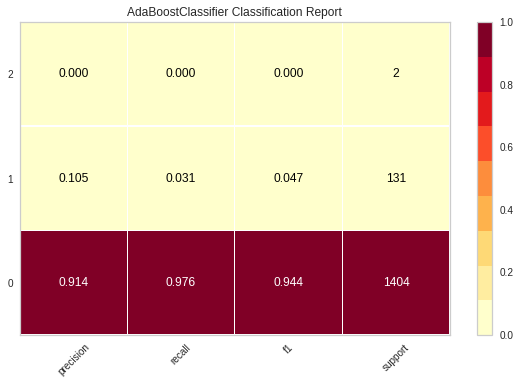

In [20]:
#Classification Report
viz = ClassificationReport(ada, classes=['0', '1', '2'], support = True)
viz.fit(trainX, trainyt)
viz.score(testX, testyt)
viz.poof()

In [21]:
importanceAda = ada.feature_importances_

matchedAda = pd.DataFrame(importanceAda,columnsNamesArr)
print(matchedAda)

                   0
state_x     0.015332
seat_pos    0.000000
alc_status  0.000000
caseyear    0.000000
state_y     0.016440
ve_total    0.000000
ve_forms    0.000000
pvh_invl    0.000000
peds        0.000000
pernotmvit  0.000000
permvit     0.064213
persons     0.007575
county      0.146136
city        0.002592
day         0.239536
month       0.033685
year        0.000000
day_week    0.000000
hour        0.066526
minute      0.018739
nhs         0.000000
route       0.061575
milept      0.011285
latitude    0.029842
longitud    0.130199
sp_jur      0.000000
harm_ev     0.013747
man_coll    0.000000
reljct1     0.000000
reljct2     0.012096
typ_int     0.027624
wrk_zone    0.000000
road_fnc    0.002263
rel_road    0.000000
lgt_cond    0.024985
weather1    0.008200
weather2    0.000000
weather     0.007074
sch_bus     0.000000
not_hour    0.000000
not_min     0.016445
arr_hour    0.030052
arr_min     0.000000
hosp_hr     0.002056
hosp_mn     0.004613
cf1         0.000000
cf2         0

In [22]:
matchedAda.sort_values(0,ascending=False)

,0
day,0.239536
county,0.146136
longitud,0.130199
hour,0.066526
permvit,0.064213
route,0.061575
month,0.033685
arr_hour,0.030052
latitude,0.029842
typ_int,0.027624


In [0]:
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold
kfolder = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=72)

In [0]:
from sklearn.model_selection import cross_val_score
import numpy as np
ytT = np.ravel(yt)
#forestScores = cross_val_score(forestGiniBoot, X, ytT, cv = kfolder)
#print(forestScores)

In [0]:
#adaScores = cross_val_score(ada, X, ytT, cv = kfolder)
#print(adaScores)